In [38]:
import numpy as np
import matplotlib.pyplot as plt
import functools
from tqdm import tqdm
import poles
import material
import scipy
import multilayer


In [3]:
# Parameters for the coated sphere
r_core_min = 1e-9
r_core_max = 250e-9
num_r_core = 2 * 10**2

r_shell_min = 0.2e-9
r_shell_max = 5e-9
num_r_shell = 2 * 10**2

middle_index_core = int(num_r_core *1 / 4)
middle_index_shell = int(num_r_shell / 2)

n_func_core = material.get_n_silica
n_func_coating = material.get_n_gold_drude_lorentz
n_func_background = material.get_n_water()
n_func_list = [n_func_core, n_func_coating, n_func_background]

multipole_order = 1

In [4]:
r_core_values = np.linspace(r_core_min, r_core_max, num_r_core)
r_shell_values = np.linspace(r_shell_min, r_shell_max, num_r_shell)
R_CORE, R_SHELL = np.meshgrid(r_core_values, r_shell_values)

Core: 63.56281407035175
Shell: 2.6120603015075377


Text(0, 0.5, 'CS')

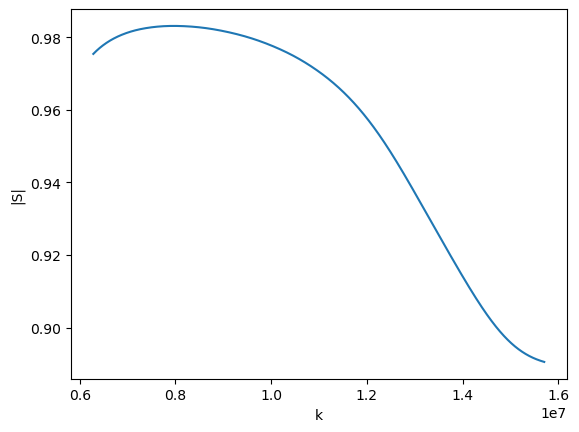

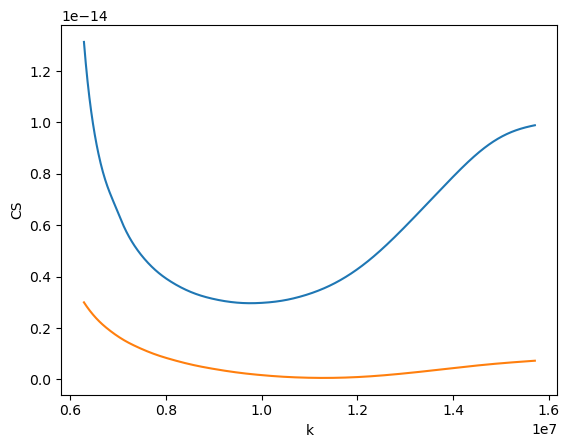

In [5]:
# Find the first pole
lam_min = 400e-9
lam_max = 1000e-9
k_min = 2 * np.pi / lam_max
k_max = 2 * np.pi / lam_min

data = []
data_cs = []
data_css = []
k_array = np.linspace(k_min, k_max, 10**3)
middle_r_core_value = r_core_values[middle_index_core]
middle_r_shell_value = r_shell_values[middle_index_shell]

r_list = [middle_r_core_value, middle_r_core_value + middle_r_shell_value]
print(f"Core: {middle_r_core_value/1e-9}")
print(f"Shell: {middle_r_shell_value/1e-9}")

for k in k_array:
    a = multilayer.get_a(k, r_list, n_func_list, multipole_order)
    data.append(np.abs(1+2*a))
    cs = multilayer.get_extinction_cross_section(k, r_list, n_func_list)
    data_cs.append(cs)
    css = multilayer.get_scattering_cross_section(k, r_list, n_func_list)
    data_css.append(css)

fig, ax = plt.subplots()
ax.plot(k_array, data)
ax.set_xlabel("k")
ax.set_ylabel("|S|")
# ax.set_ylim(0.9,1.1)

fig, ax = plt.subplots()
ax.plot(k_array, data_cs)
ax.plot(k_array, data_css)
ax.set_xlabel("k")
ax.set_ylabel("CS")

100%|██████████| 100/100 [00:00<00:00, 104.63it/s]


Text(0, 0.5, 'Im(k)')

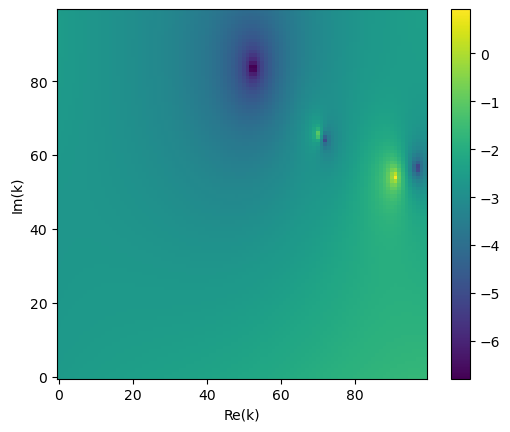

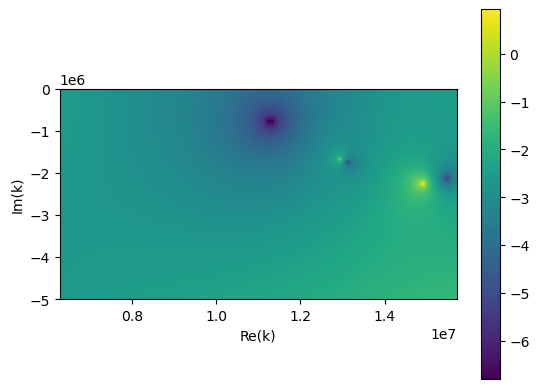

In [6]:
# Get the pole from a!
imag_k_min = -5e6
imag_k_max =0
num_reals = 1 * 10**2
num_imags = 1 * 10**2

k_reals = np.linspace(k_min, k_max, num_reals)
k_imags = np.linspace(imag_k_min, imag_k_max, num_imags)
R, I = np.meshgrid(k_reals, k_imags)
k_array = R + 1j * I
data = np.zeros((num_reals, num_imags))

for i in tqdm(range(num_reals)):
    for j in range(num_imags):
        k = k_array[i, j]
        data[i, j] = np.abs(
            multilayer.get_a(k, r_list, n_func_list, multipole_order)
        )
# 2D Plot
fig, ax = plt.subplots()
im = ax.imshow(np.log(data), origin="lower")
cbar = fig.colorbar(im, ax=ax)
ax.set_xlabel("Re(k)")
ax.set_ylabel("Im(k)")
fig, ax = plt.subplots()
im = ax.imshow(
    np.log(data), origin="lower", extent=(k_min, k_max, imag_k_min, imag_k_max)
)
cbar = fig.colorbar(im, ax=ax)
ax.set_xlabel("Re(k)")
ax.set_ylabel("Im(k)")

zero guess: (11328773.508399557-757575.7575757578j)
Value at zero guess: 0.0011283051397654724

zero real: (11283094.512515437-775889.3773984069j)
Value at real zero: 7.629177924941575e-13


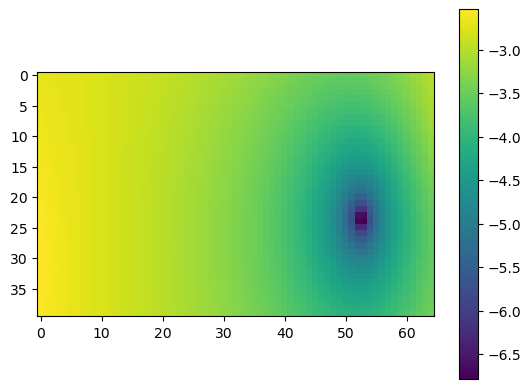

In [7]:
truncated_data = data[60:, 0:65]
truncated_k = R[60:, 0:65] + 1j * I[60:, 0:65]

fig, ax = plt.subplots()
im = ax.imshow(np.log(np.abs(truncated_data)))
cbar = fig.colorbar(im, ax=ax)

indices = np.where(np.isclose(truncated_data, np.min(truncated_data)))
u, v = indices
u = int(u[0])
v = int(v[0])
zero_guess = truncated_k[u, v]
value_guess = truncated_data[u, v]
print(f"zero guess: {zero_guess}")
print(f"Value at zero guess: {np.abs(value_guess)}")
print("")
zero = poles.find_zero_a_multilayer(
    zero_guess, r_list, n_func_list, multipole_order
)
print(f"zero real: {zero}")
print(
    f"Value at real zero: {np.abs(multilayer.get_a(zero, r_list, n_func_list, multipole_order))}"
)

In [8]:
# wavelength of the pole
l = 2 * np.pi / zero.real
print(f"pole k: {zero/1e7}")
print(f"vacuum wavelength: {l/1e-9}")
print(f"background wavelength: {np.real(l/n_func_background(zero.real))/1e-9}")

pole k: (1.1283094512515437-0.07758893773984069j)
vacuum wavelength: 556.8672051989062
background wavelength: 417.7599198431058


In [9]:
# Residue of ws_k at pole (should be i)
func = functools.partial(
    multilayer.get_ws_ainv_k,
    r_list=r_list,
    n_func_list=n_func_list,
    multipole_order=multipole_order,
    dk=1e1,
)
res_ws_k = poles.get_residue(func, zero, radius=1e2)
print(res_ws_k)

(0.00045326528951642847+1.0015244695081773j)


In [10]:
# Residue of ws_nb at pole (should be i)
func = functools.partial(
    multilayer.get_ws_ainv_nb_bulk,
    r_list=r_list,
    n_func_list=n_func_list,
    multipole_order=multipole_order,
    dnb=1e-6,
)
res_ws_nb = poles.get_residue(func, zero, radius=1e2)
print(res_ws_nb)

(-3394173.4521827735-11415552.203766651j)


(11408.784723550081-3408.161509262398j)
(11415.552203766652-3394.1734521827734j)


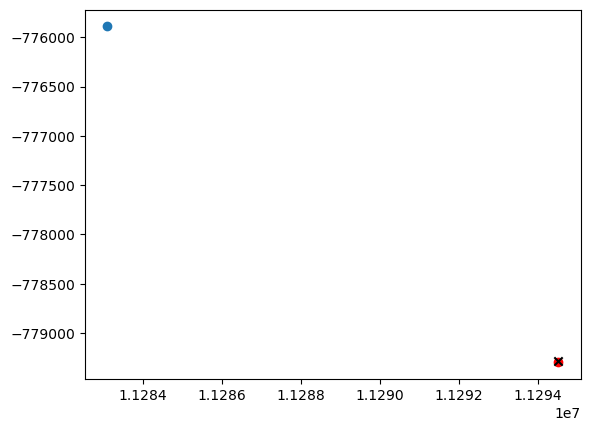

In [11]:
# Check that the pole shift is working properly
dnb = 0.001


def n_func_background_perturbed(k):
    return n_func_background(k) + dnb

new_n_func_list = [n_func_core, n_func_coating, n_func_background_perturbed]

zero_before = zero
zero_after = poles.find_zero_a_multilayer(
    zero_before,
    r_list,
    new_n_func_list,
    multipole_order,
)
zero_shift_direct = zero_after - zero_before
zero_shift_theory = 1j * dnb * res_ws_nb

print(zero_shift_direct)
print(zero_shift_theory)
fig, ax = plt.subplots()
ax.scatter(zero_before.real, zero_before.imag)
ax.scatter(
    zero_before.real + zero_shift_direct.real,
    zero_before.imag + zero_shift_direct.imag,
    color="red",
)
ax.scatter(
    zero_before.real + zero_shift_theory.real,
    zero_before.imag + zero_shift_theory.imag,
    marker="x",
    color="black",
)

In [12]:
print(R_CORE[0:3, 0:3])
print("---")
print(R_SHELL[0:3, 0:3])
print(R_CORE.shape)
print(R_SHELL.shape)
print(R_CORE[middle_index_shell, middle_index_core ])
print(R_SHELL[middle_index_shell, middle_index_core ])
print(r_list)

[[1.00000000e-09 2.25125628e-09 3.50251256e-09]
 [1.00000000e-09 2.25125628e-09 3.50251256e-09]
 [1.00000000e-09 2.25125628e-09 3.50251256e-09]]
---
[[2.00000000e-10 2.00000000e-10 2.00000000e-10]
 [2.24120603e-10 2.24120603e-10 2.24120603e-10]
 [2.48241206e-10 2.48241206e-10 2.48241206e-10]]
(200, 200)
(200, 200)
6.356281407035175e-08
2.6120603015075378e-09
[6.356281407035175e-08, 6.617487437185928e-08]


In [13]:
# Let's find all the poles
zero_grid = np.zeros(R_CORE.shape, dtype=np.complex128)
new_raw_zero = zero

zero_grid[middle_index_shell, middle_index_core ] = zero

# Fill out the column going down from the first pole
old_zero = zero
for i in tqdm(range(middle_index_shell + 1, num_r_shell)):
    r_core = middle_r_core_value
    r_shell = R_SHELL[i,0]
    new_r_list = [r_core, r_core + r_shell]
    new_zero = poles.find_zero_a_multilayer(
        old_zero,
        new_r_list,
        n_func_list,
        multipole_order,
    )  
    zero_grid[i, middle_index_core] = new_zero
    old_zero = new_zero

# Fill out the column going UP from the first pole
old_zero = zero
for i in tqdm(range(middle_index_shell - 1, -1, -1)):
    r_core = middle_r_core_value
    r_shell = R_SHELL[i,0]
    new_r_list = [r_core, r_core + r_shell]
    new_zero = poles.find_zero_a_multilayer(
        old_zero,
        new_r_list,
        n_func_list,
        multipole_order,
    )  
    zero_grid[i, middle_index_core] = new_zero
    old_zero = new_zero

# Fill out remainder to the RIGHT of the first column
for j in tqdm(range(middle_index_core + 1, num_r_core)):
    r_core = R_CORE[0, j]
    old_zero = zero_grid[0, j-1]
    for i in range(num_r_shell):
        r_shell = R_SHELL[i, 0]
        new_r_list = [r_core, r_core + r_shell]
        new_zero = poles.find_zero_a_multilayer(
            old_zero,
            new_r_list,
            n_func_list,
            multipole_order,
        )  
        zero_grid[i, j] = new_zero
        old_zero = new_zero

# Fill out remainder to the LEFT of the first column
for j in tqdm(range(middle_index_core - 1, -1, -1)):
    r_core = R_CORE[0, j]
    old_zero = zero_grid[0, j+1]

    for i in range(num_r_shell):
        r_shell = R_SHELL[i, 0]
        new_r_list = [r_core, r_core + r_shell]
        new_zero = poles.find_zero_a_multilayer(
            old_zero,
            new_r_list,
            n_func_list,
            multipole_order,
        )  
        zero_grid[i, j] = new_zero
        old_zero = new_zero

100%|██████████| 50/50 [02:34<00:00,  3.10s/it]


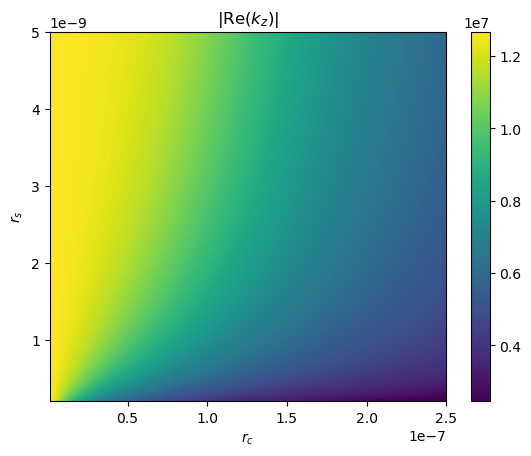

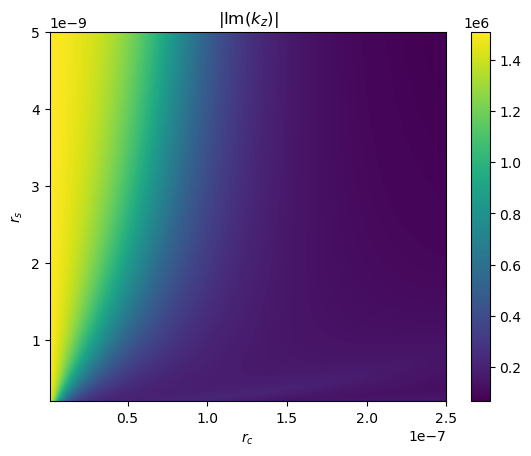

In [14]:
fig, ax = plt.subplots()
im = ax.imshow(
    np.abs(zero_grid.real),
    extent=(R_CORE[0, 0], R_CORE[0, -1], R_SHELL[0, 0], R_SHELL[-1, 0]),
    origin="lower",
)
ax.set_aspect("auto")
ax.set_title(r"$|\mathrm{Re}(k_z)|$")
ax.set_xlabel(r"$r_c$")
ax.set_ylabel(r"$r_s$")
cbar = fig.colorbar(im, ax=ax)

fig, ax = plt.subplots()
im = ax.imshow(
    np.abs(zero_grid.imag),
    extent=(R_CORE[0, 0], R_CORE[0, -1], R_SHELL[0, 0], R_SHELL[-1, 0]),
    origin="lower",
)
ax.set_aspect("auto")
ax.set_title(r"$|\mathrm{Im}(k_z)|$")
ax.set_xlabel(r"$r_c$")
ax.set_ylabel(r"$r_s$")
cbar = fig.colorbar(im, ax=ax)

In [15]:
# Let's find all the poles
sensitivity_data = np.zeros(R_CORE.shape, dtype=np.complex128)
sensitivity_real = np.zeros(R_CORE.shape, dtype=np.complex128)

delta_nb = 1e-8

for i in tqdm(range(num_r_core)):

    # Get the new pole for the minimum shell width
    new_r = R_CORE[0, i]

    for j in range(num_r_shell):
        new_r_shell = R_SHELL[j, 0]
        new_r_coating = new_r + new_r_shell
        new_r_list = [new_r, new_r_coating]

        next_zero = zero_grid[j, i]
        func = functools.partial(
            multilayer.get_ws_ainv_nb_bulk,
            r_list=new_r_list,
            n_func_list=n_func_list,
            multipole_order=multipole_order,
        )
        res_ws_nb = poles.get_residue(func, next_zero, radius=1e3)
        sensitivity = 1j * res_ws_nb
        sensitivity_data[j, i] = sensitivity

        # Get the real value

        perturbed_zero = poles.find_zero_a_multilayer(
            next_zero,
            new_r_list,
            [n_func_core, n_func_coating, lambda k: n_func_background(k) + delta_nb],
            1,
        )
        sensitivity_real[j, i] = (perturbed_zero- next_zero) / delta_nb

100%|██████████| 200/200 [12:37<00:00,  3.79s/it]


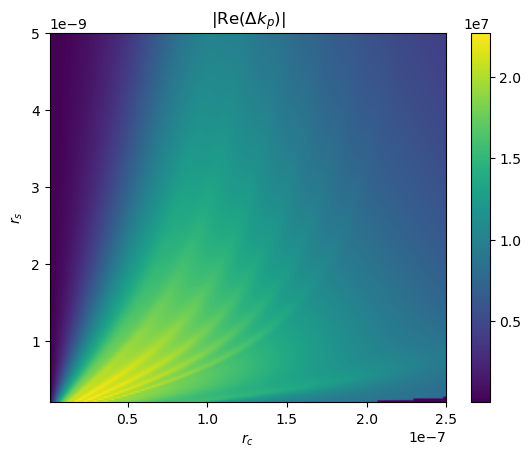

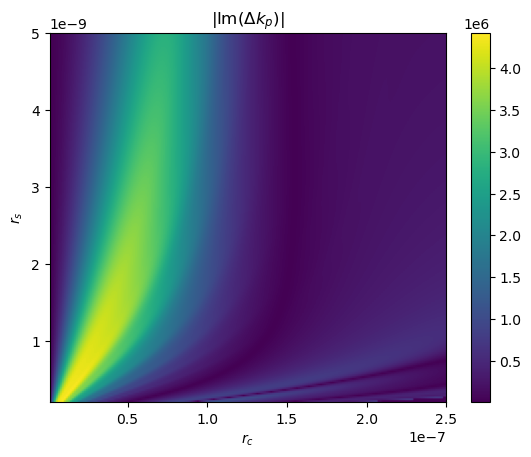

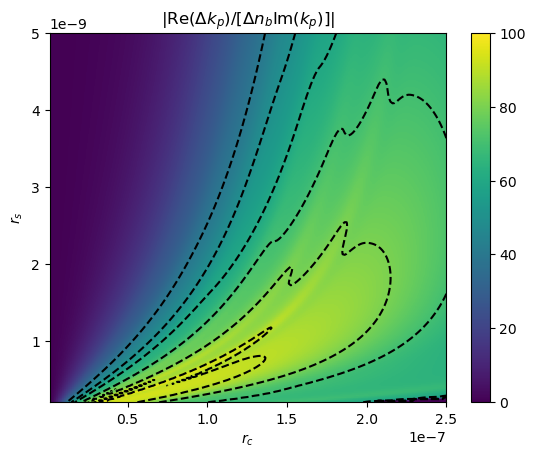

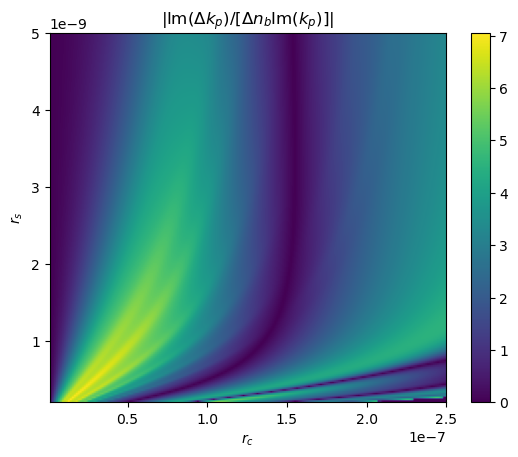

In [16]:
fig, ax = plt.subplots()
im = ax.imshow(
    np.abs(sensitivity_data.real),
    extent=(R_CORE[0, 0], R_CORE[0, -1], R_SHELL[0, 0], R_SHELL[-1, 0]),
    origin="lower",
)
ax.set_aspect("auto")
ax.set_title(r"$|\mathrm{Re}(\Delta k_p)|$")
ax.set_xlabel(r"$r_c$")
ax.set_ylabel(r"$r_s$")
cbar = fig.colorbar(im, ax=ax)

fig, ax = plt.subplots()
im = ax.imshow(
    np.abs(sensitivity_data.imag),
    extent=(R_CORE[0, 0], R_CORE[0, -1], R_SHELL[0, 0], R_SHELL[-1, 0]),
    origin="lower",
)
ax.set_aspect("auto")
ax.set_title(r"$|\mathrm{Im}(\Delta k_p)|$")
ax.set_xlabel(r"$r_c$")
ax.set_ylabel(r"$r_s$")
cbar = fig.colorbar(im, ax=ax)


fig, ax = plt.subplots()
im = ax.imshow(
    np.abs(sensitivity_data.real / zero_grid.imag),
    extent=(R_CORE[0, 0], R_CORE[0, -1], R_SHELL[0, 0], R_SHELL[-1, 0]),
    origin="lower",
    vmin=0,
    vmax=100
)
ax.set_aspect("auto")
ax.set_title(r"$|\mathrm{Re}(\Delta k_p)/[\Delta n_b \mathrm{Im}(k_p)]|$")
ax.set_xlabel(r"$r_c$")
ax.set_ylabel(r"$r_s$")
cbar = fig.colorbar(im, ax=ax)
contour_levels = [40,50, 60, 70, 80,90]
contours = ax.contour(
    R_CORE,
    R_SHELL,
    np.abs(sensitivity_data.real / zero_grid.imag),
    levels=contour_levels,  # Set the number of contour levels, or define specific levels
    colors="black",  # Set contour color
    linestyles="dashed",
)
# plt.savefig('heat.svg', dpi=300, bbox_inches='tight')
plt.savefig('zerofom.svg', dpi=300, bbox_inches='tight')

# fig, ax = plt.subplots()
# im = ax.imshow(
#     np.abs(sensitivity_real.real / zero_grid.imag),
#     extent=(R_CORE[0, 0], R_CORE[0, -1], R_SHELL[0, 0], R_SHELL[-1, 0]),
#     origin="lower",
#     vmin=0,
# )
# ax.set_aspect("auto")
# ax.set_title(r"$|\mathrm{Re}(\Delta k_p)/[\Delta n_b \mathrm{Im}(k_p)]|$")
# ax.set_xlabel(r"$r_c$")
# ax.set_ylabel(r"$r_s$")
# cbar = fig.colorbar(im, ax=ax)
# contour_levels = [2, 4, 6, 8, 10, 11, 11.4]
# contours = ax.contour(
#     R_CORE,
#     R_SHELL,
#     np.abs(sensitivity_real.real / zero_grid.imag),
#     levels=contour_levels,  # Set the number of contour levels, or define specific levels
#     colors="black",  # Set contour color
#     linestyles="dashed",
# )
# plt.savefig('heat.svg', dpi=300, bbox_inches='tight')
fig, ax = plt.subplots()
im = ax.imshow(
    np.abs(sensitivity_data.imag / zero_grid.imag),
    extent=(R_CORE[0, 0], R_CORE[0, -1], R_SHELL[0, 0], R_SHELL[-1, 0]),
    origin="lower",
    vmin=0,
)

ax.set_aspect("auto")
ax.set_title(r"$|\mathrm{Im}(\Delta k_p)/[\Delta n_b \mathrm{Im}(k_p)]|$")
ax.set_xlabel(r"$r_c$")
ax.set_ylabel(r"$r_s$")
cbar = fig.colorbar(im, ax=ax)
# contour_levels = [40,50, 60, 70, 80,90]
# contours = ax.contour(
#     R_CORE,
#     R_SHELL,
#     np.abs(sensitivity_data.real / zero_grid.imag),
#     levels=contour_levels,  # Set the number of contour levels, or define specific levels
#     colors="black",  # Set contour color
#     linestyles="dashed",
# )


96.5916250663374
0 20
r_core = 2.60251256281407e-08
r_shell = 2e-10
pole = (0.7619486819955188-0.026255437936148228j)
6.966489597828042


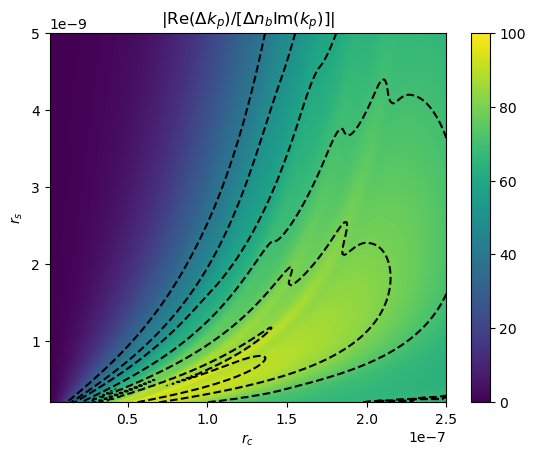

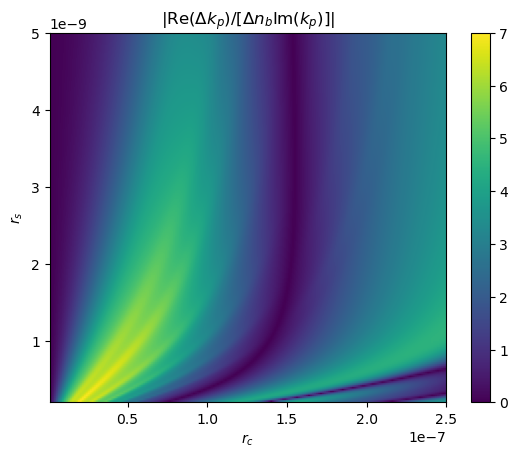

In [17]:
fig, ax = plt.subplots()
im = ax.imshow(
    np.abs(sensitivity_data.real / zero_grid.imag)[5:],
    extent=(R_CORE[0, 0], R_CORE[0, -1], R_SHELL[0, 0], R_SHELL[-1, 0]),
    origin="lower",
    vmin=0,
    vmax=100,
)
ax.set_aspect("auto")
ax.set_title(r"$|\mathrm{Re}(\Delta k_p)/[\Delta n_b \mathrm{Im}(k_p)]|$")
ax.set_xlabel(r"$r_c$")
ax.set_ylabel(r"$r_s$")
cbar = fig.colorbar(im, ax=ax)
contour_levels = [40,50, 60, 70, 80,90]
contours = ax.contour(
    R_CORE,
    R_SHELL,
    np.abs(sensitivity_data.real / zero_grid.imag),
    levels=contour_levels,  # Set the number of contour levels, or define specific levels
    colors="black",  # Set contour color
    linestyles="dashed",
)

print(np.max(np.abs(sensitivity_data.real / zero_grid.imag)[5:]))


# plt.savefig('heat.svg', dpi=300, bbox_inches='tight')
plt.savefig('zerofom.svg', dpi=300, bbox_inches='tight')


fig, ax = plt.subplots()
im = ax.imshow(
    np.abs(sensitivity_data.imag / zero_grid.imag)[5:],
    extent=(R_CORE[0, 0], R_CORE[0, -1], R_SHELL[0, 0], R_SHELL[-1, 0]),
    origin="lower",
    vmin=0,
    vmax=7
)
ax.set_aspect("auto")
ax.set_title(r"$|\mathrm{Re}(\Delta k_p)/[\Delta n_b \mathrm{Im}(k_p)]|$")
ax.set_xlabel(r"$r_c$")
ax.set_ylabel(r"$r_s$")
cbar = fig.colorbar(im, ax=ax)
# contour_levels = [2,4,6]
# contours = ax.contour(
#     R_CORE,
#     R_SHELL,
#     np.abs(sensitivity_data.imag / zero_grid.imag),
#     levels=contour_levels,  # Set the number of contour levels, or define specific levels
#     colors="black",  # Set contour color
#     linestyles="dashed",
# )
# plt.savefig('heat.svg', dpi=300, bbox_inches='tight')
u, v = np.where(
    np.isclose(
        np.abs(sensitivity_data.imag / zero_grid.imag)[10:],
        np.max(np.abs(sensitivity_data.imag / zero_grid.imag)[10:]),
    )
)
u, v = u[0], v[0]
print(u, v)
print(f"r_core = {R_CORE[u,v]}")
print(f"r_shell = {R_SHELL[u,v]}")
print(f"pole = {zero_grid[u,v]/1e7}")


plt.savefig('zerofom_imag.svg', dpi=300, bbox_inches='tight')
print(np.max(np.abs(sensitivity_data.imag / zero_grid.imag)[5:]))


96.5916250663374


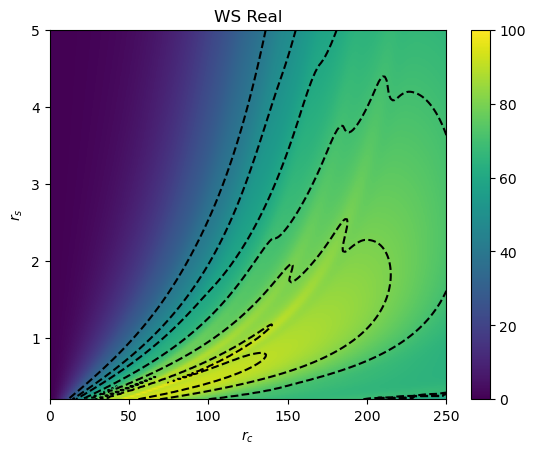

In [77]:
fig, ax = plt.subplots()
im = ax.imshow(
    np.abs(sensitivity_data.real / zero_grid.imag)[3:],
    extent=(R_CORE[0, 0], R_CORE[0, -1], R_SHELL[0, 0], R_SHELL[-1, 0]),
    origin="lower",
    vmin=0,
    vmax=100,
)
ax.set_aspect("auto")
ax.set_title(r"WS Real")
ax.set_xlabel(r"$r_c$")
ax.set_ylabel(r"$r_s$")
cbar = fig.colorbar(im, ax=ax)
contour_levels = [40,50, 60, 70, 80,90]
contours = ax.contour(
    R_CORE,
    R_SHELL,
    scipy.ndimage.gaussian_filter(np.abs(sensitivity_data.real / zero_grid.imag),sigma=0),
    levels=contour_levels,  # Set the number of contour levels, or define specific levels
    colors="black",  # Set contour color
    linestyles="dashed",
)
ax.set_xticks(np.array([r_shell_min/(1e-9),50, 100, 150, 200, 250]) * 1e-9)
ax.set_xticklabels([f"0", "50", "100", "150", "200", "250"])
ax.set_yticks(np.array([1, 2, 3, 4, 5]) * 1e-9)
ax.set_yticklabels(["1", "2", "3", "4", "5"])

print(np.max(np.abs(sensitivity_data.real / zero_grid.imag)[5:]))


# plt.savefig('heat.svg', dpi=300, bbox_inches='tight')
plt.savefig('zerofom.svg', dpi=300)


96.5916250663374


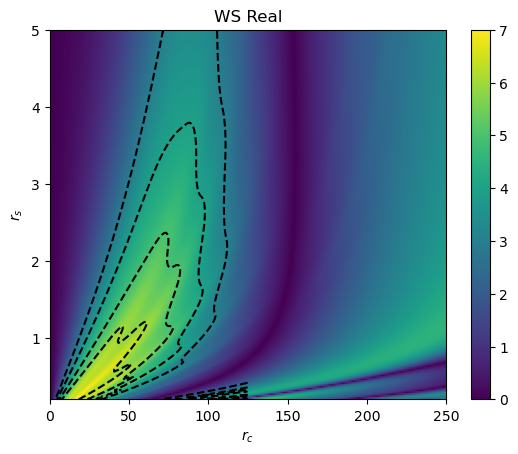

In [76]:
fig, ax = plt.subplots()
im = ax.imshow(
    np.abs(sensitivity_data.imag / zero_grid.imag)[3:],
    extent=(R_CORE[0, 0], R_CORE[0, -1], R_SHELL[0, 0], R_SHELL[-1, 0]),
    origin="lower",
    vmin=0,
    vmax=7
)
ax.set_aspect("auto")
ax.set_title(r"WS Real")
ax.set_xlabel(r"$r_c$")
ax.set_ylabel(r"$r_s$")
cbar = fig.colorbar(im, ax=ax)
contour_levels = [3,4,5,6]
contours = ax.contour(
    R_CORE[:,:100],
    R_SHELL[:,:100],
    scipy.ndimage.gaussian_filter(np.abs(sensitivity_data.imag / zero_grid.imag),sigma=0)[:,:100],
    levels=contour_levels,  # Set the number of contour levels, or define specific levels
    colors=["black","black","black","black"],  # Set contour color
    linestyles="dashed",
)

# contour_levels = [4]
# contours = ax.contour(
#     R_CORE[:,100:],
#     R_SHELL[:,100:],
#     scipy.ndimage.gaussian_filter(np.abs(sensitivity_data.imag / zero_grid.imag),sigma=0)[:,100:],
#     levels=contour_levels,  # Set the number of contour levels, or define specific levels
#     colors=["white"],  # Set contour color
#     linestyles="dashed",
# )


ax.set_xticks(np.array([r_shell_min/(1e-9),50, 100, 150, 200, 250]) * 1e-9)
ax.set_xticklabels([f"0", "50", "100", "150", "200", "250"])
ax.set_yticks(np.array([1, 2, 3, 4, 5]) * 1e-9)
ax.set_yticklabels(["1", "2", "3", "4", "5"])

print(np.max(np.abs(sensitivity_data.real / zero_grid.imag)[5:]))


# plt.savefig('heat.svg', dpi=300, bbox_inches='tight')
plt.savefig('zerofom_imag.svg', dpi=300)